In [1]:
import pandas as pd
import sqlalchemy
from matplotlib import pyplot as plt
import datetime
import copy
import numpy as np
from scipy.stats import stats, ttest_ind # ANOVA and t-test
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
df = pd.read_csv("/home/memari/jhu_centering/tables/locations.csv", parse_dates=['date'])
col = df.columns

In [3]:
# find the first day
def find_first_day(device_id, df):
    df_target = df[df['device_id']==device_id]
    return min(df_target['date'])
def halve(df):
    first_day = {device_id:find_first_day(device_id, df) 
                 for device_id in set(df['device_id'].tolist())
                if find_first_day(device_id, df)>=datetime.date(year=2022,month=11,day=11)}
    df = df[df['device_id'].isin(first_day)]
    df['day'] = df.apply(lambda x: 1+(x['date']-first_day[x['device_id']]).days, axis = 1)
    df_1_14 = df[df['day']<=14]
    df_15_28 = df[(df['day']>14) & (df['day']<=28)]
    return df_1_14,df_15_28
df_1_14,df_15_28 = halve(df)

In [4]:
col = df.columns.tolist()
col.insert(0,'day')
print(col)

['day', 'device_id', 'date', 'nunique', 'count']


In [5]:
df_1_14 = df_1_14[col]
df_1_14

,day,device_id,date,nunique,count
0,1,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-19,56,150
1,2,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-20,346,960
2,3,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-21,355,960
3,4,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-22,358,960
4,5,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-23,235,960
...,...,...,...,...,...
3025,10,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-16,60,1036
3026,11,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-17,78,784
3027,12,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-18,343,1216
3028,13,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-19,110,680


In [6]:
df_15_28 = df_15_28[col]
df_15_28

,day,device_id,date,nunique,count
14,15,00e17b8a-4b0f-4230-bd26-3df2853e8916,2023-01-02,82,692
15,16,00e17b8a-4b0f-4230-bd26-3df2853e8916,2023-01-03,20,351
16,17,00e17b8a-4b0f-4230-bd26-3df2853e8916,2023-01-04,300,959
17,18,00e17b8a-4b0f-4230-bd26-3df2853e8916,2023-01-05,329,960
18,19,00e17b8a-4b0f-4230-bd26-3df2853e8916,2023-01-06,31,58
...,...,...,...,...,...
3038,23,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-29,400,1497
3039,24,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-30,509,1134
3040,25,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-31,372,1262
3041,26,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2023-01-01,481,1223


In [7]:
# get the groups form the survey data
df_group = pd.read_csv('/data/meditation/majid/surveys/0.csv',
                       skiprows=[1, 2])[['Study ID', 'Group']]
df_group.columns = ['survey_id', 'group']
df_id = pd.read_csv('/home/memari/jhu_centering/tables/id.csv')

df_group = df_id.merge(df_group, on='survey_id', how='left')
df_group.rename(columns={'device_id1': 'device_id'}, inplace=True)
df_group = df_group.rename(columns={'group_x': 'group'})

In [8]:
df_group

,device_id,survey_id,device_id2,group,group_y
0,4a23c5dc-9a50-4d46-a12d-dd94ee98270f,8415477,NaN,Experimental Condition,Experimental Condition
1,f3845ba4-8702-42cf-a14f-051c46f66b61,15027959,NaN,Active Control,Active Control
2,ae02314b-a607-41b9-9507-28ffa1babed7,73386307,NaN,Active Control,Active Control
3,b460f89e-fd76-46ff-a960-989d74fcb66a,87785016,NaN,Active Control,Active Control
4,e5048fab-dc20-4d99-8cea-220a5a2750e0,14851895,NaN,Passive Control,Passive Control
...,...,...,...,...,...
70,780c9b18-72d3-4714-858d-3c91b3719155,21788465,NaN,Active Control,Active Control
71,a1118578-bbb4-47ef-b784-7d5bd09ad8b5,7389236,NaN,Passive Control,Passive Control
72,00e17b8a-4b0f-4230-bd26-3df2853e8916,69546645,NaN,Experimental Condition,Experimental Condition
73,029e57cb-fa0d-479d-abd2-9cb5745f219d,72690342,NaN,Passive Control,Passive Control


In [9]:
df_1_14 = df_1_14.merge(df_group[['device_id', 'group']],
                   on='device_id', how='left')
df_15_28 = df_15_28.merge(df_group[['device_id', 'group']],
                   on='device_id', how='left')

In [10]:
df_1_14

,day,device_id,date,nunique,count,group
0,1,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-19,56,150,Experimental Condition
1,2,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-20,346,960,Experimental Condition
2,3,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-21,355,960,Experimental Condition
3,4,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-22,358,960,Experimental Condition
4,5,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-23,235,960,Experimental Condition
...,...,...,...,...,...,...
1023,10,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-16,60,1036,Experimental Condition
1024,11,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-17,78,784,Experimental Condition
1025,12,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-18,343,1216,Experimental Condition
1026,13,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-19,110,680,Experimental Condition


In [11]:
grouped_1_14 = df_1_14 .groupby(['group'])
df_dict = {group: data for group, data in grouped_1_14}
active_control_1_14 = df_dict['Active Control']
experimental_condition_1_14 = df_dict['Experimental Condition']
passive_control_1_14 = df_dict['Passive Control']

In [12]:
grouped_15_28 = df_15_28 .groupby(['group'])
df_dict = {group: data for group, data in grouped_15_28}
active_control_15_28 = df_dict['Active Control']
experimental_condition_15_28 = df_dict['Experimental Condition']
passive_control_15_28 = df_dict['Passive Control']

In [13]:
to_remove = ['day', 'device_id', 'date']
my_list = [item for item in col if item not in to_remove]

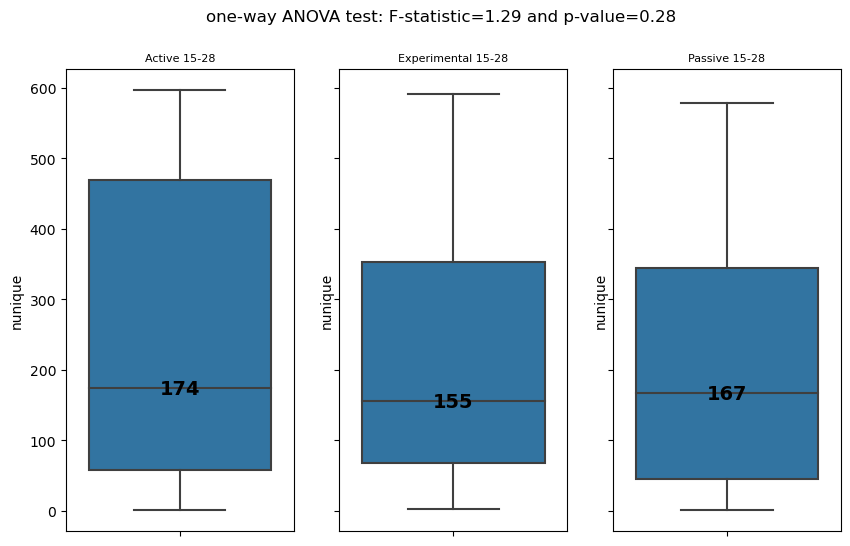

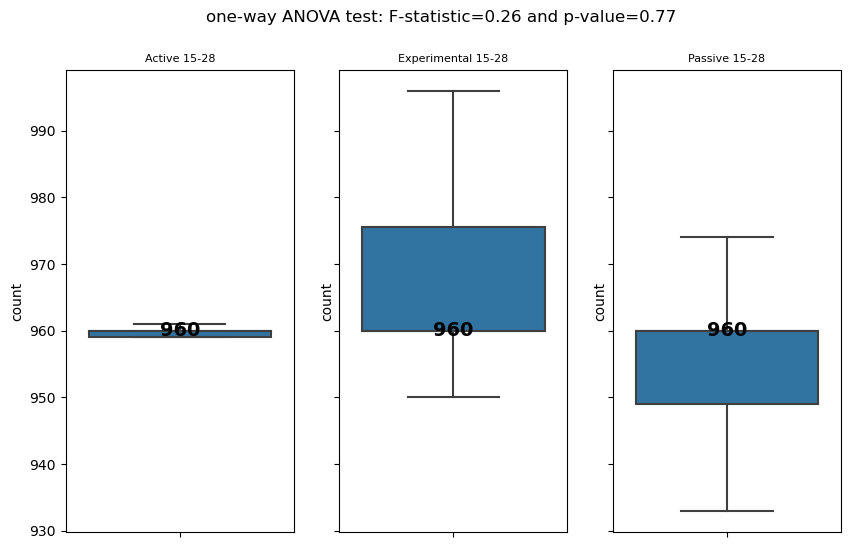

In [14]:
for clm in my_list:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6), sharey=True)

    sns.boxplot(y=active_control_15_28[clm], orient="v", showfliers=False, ax=ax1)

    sns.boxplot(y=experimental_condition_15_28[clm],orient="v", showfliers=False, ax=ax2)

    sns.boxplot(y=passive_control_15_28[clm], orient="v", showfliers=False, ax=ax3)


    ax1.set_title("Active 15-28", fontsize=8)
    m1 = int(active_control_15_28[clm].median())
    ax1.text(0, m1, m1, ha='center', va='center',fontsize=14, fontdict={'fontweight': 'bold'})
    
    ax2.set_title("Experimental 15-28", fontsize=8)
    m2 = int(experimental_condition_15_28[clm].median())
    ax2.text(0, m2, m2, ha='center', va='center',fontsize=14, fontdict={'fontweight': 'bold'})
   
    ax3.set_title("Passive 15-28", fontsize=8)
    m3 = int(passive_control_15_28[clm].median())
    ax3.text(0, m3, m3, ha='center', va='center',fontsize=14, fontdict={'fontweight': 'bold'})

    stat, p = stats.f_oneway(active_control_15_28[clm], experimental_condition_15_28[clm], passive_control_15_28[clm])
    mytext = 'one-way ANOVA test: F-statistic={:.2f} and p-value={:.2f}'.format(
        stat, p)
    plt.suptitle(mytext)
    plt.show()